# Caso de Negocio

### Puntaje de Valor del Cliente



En un entorno competitivo, las empresas buscan no solo adquirir nuevos clientes, sino también retener a los existentes y maximizar el valor que cada cliente aporta a lo largo de su vida. La personalización y la segmentación de clientes se han vuelto esenciales para aumentar la efectividad de las campañas de marketing.

Oportunidad: La mayoría de las empresas tienen datos valiosos sobre sus clientes, pero no siempre los utilizan de manera efectiva para clasificar y predecir el comportamiento futuro. Implementar un sistema de puntaje puede ayudar a las empresas a identificar a los clientes más valiosos y aquellos que necesitan atención.

# Selección de Variables

## Variable Objetivo: 

La variable objetivo será el Puntaje Total del Cliente, que se calcula en función de múltiples métricas relacionadas con el comportamiento de compra y la lealtad del cliente.

Las métricas que se utilizarán para calcular el puntaje incluyen:

- **Frecuencia de Compra:** Número de transacciones realizadas por el cliente.
- **Gasto Total:** Total gastado por el cliente en un período determinado.
- **Antigüedad del Cliente:** Tiempo que el cliente ha estado activo (en días).

## Variables Independientes

### ayuda

# Selección de Datos

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.calibration import LabelEncoder

In [299]:
df = pd.read_csv('data/sales-transactions.csv', encoding='latin-1')

df['Fecha'] = pd.to_datetime(df['Fecha'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10756\2488151222.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha'] = pd.to_datetime(df['Fecha'])


In [300]:
df_1 = df.groupby(['Clave_Cliente','Transaccion']).agg({
    'Importe': 'sum',  # Valor total gastado por cliente hasta la fecha
    'Cantidad':'sum'
}).reset_index().groupby('Clave_Cliente').agg({
        'Transaccion':'count',
        'Importe': 'sum',
        'Cantidad': 'sum'
    }).reset_index().assign(importe_promedio = lambda x: x['Importe']/x['Transaccion'],
                            cantidad_promedio = lambda x: x['Cantidad']/x['Transaccion'])

df_2 = df.groupby('Clave_Cliente').agg(
    Fecha_Min=('Fecha', 'min'),
    Fecha_Max=('Fecha', 'max')
).reset_index().assign(dias = lambda x:  (x['Fecha_Max']-x['Fecha_Min']).dt.days+1)


df_merged = df_1.merge(df_2,how='inner',on='Clave_Cliente')

In [301]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0,100))

scaled_values = minmaxscaler.fit_transform(df_merged[['Transaccion','Importe','dias']].values)
scaled_df = pd.DataFrame(scaled_values, columns=['transaccion','importe','dias'])
scaled_df = scaled_df.assign(puntaje = lambda x: x['transaccion']*0.30 + x['importe']*0.60+x['dias']*0.10)

In [302]:
df_premodel = df[['Clave_Cliente','No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo']].drop_duplicates()

df_premodel = df_premodel.merge(df_merged, on='Clave_Cliente',how='inner')

In [303]:
df_premodel = df_premodel[['No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo','importe_promedio','cantidad_promedio']]

df_premodel['puntaje'] = scaled_df['puntaje'].values

In [304]:
lbl_encoder = LabelEncoder()

df_model = df_premodel.copy().reset_index(drop=True)
df_model['Estado_Civil'] = lbl_encoder.fit_transform(df_model['Estado_Civil'])
df_model['Estado'] = lbl_encoder.fit_transform(df_model['Estado'])
df_model['Sexo'] = lbl_encoder.fit_transform(df_model['Sexo'])
df_model['Grupo'] = lbl_encoder.fit_transform(df_model['Grupo'])

# EDA

AYUDA (gráficas representativas para cada cada una de las características, ya que cuando elprofe prguntó si por ejemplo variable x tiene más impacto en el modelo, a qué valores exactamente tiene esa variable x, la rpta estaba en las gráficas de tendencia de cada variable (al menos de las más representativas, ver + adelante))

# Modelos de Regresión

In [305]:
x_train, x_test, y_train, y_test =  train_test_split(df_model.drop(columns='puntaje'),df_model['puntaje'],test_size=0.3)

In [310]:
list_metrics = []
def save_metrics(model, y_test,predictions):
    rmse = root_mean_squared_error(y_test,predictions)
    r2 = r2_score(y_test,predictions)
    
    list_metrics.append([model.__class__.__name__,rmse,r2])

## Modelo 1: 

In [311]:
regressor_1 = DecisionTreeRegressor(criterion='friedman_mse')

regressor_1.fit(x_train, y_train)
predictions_1 = regressor_1.predict(x_test)

save_metrics(regressor_1, y_test, predictions_1)

### Impacto de Variables en el Modelo 1

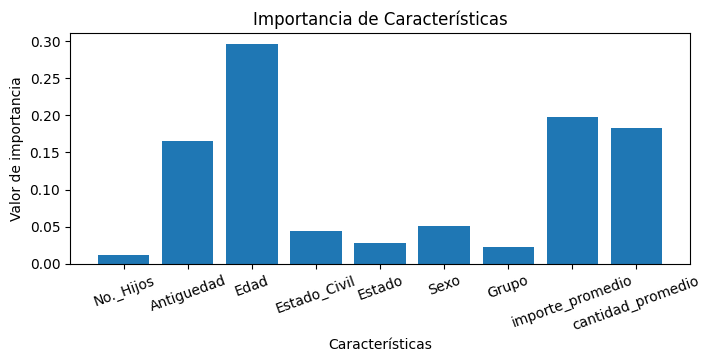

In [312]:
plt.figure(figsize=(8, 3))
plt.bar(regressor_1.feature_names_in_, regressor_1.feature_importances_)
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Valor de importancia')
plt.xticks(rotation=20)
plt.show()

### Evaluación de Modelo 1: 

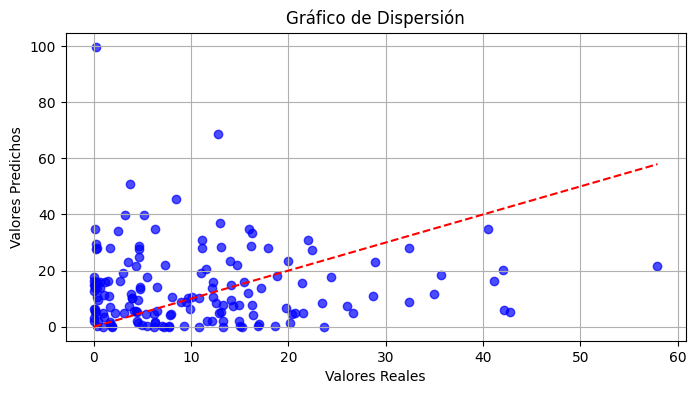

In [313]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(y_test, predictions_1, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Gráfico de Dispersión')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()


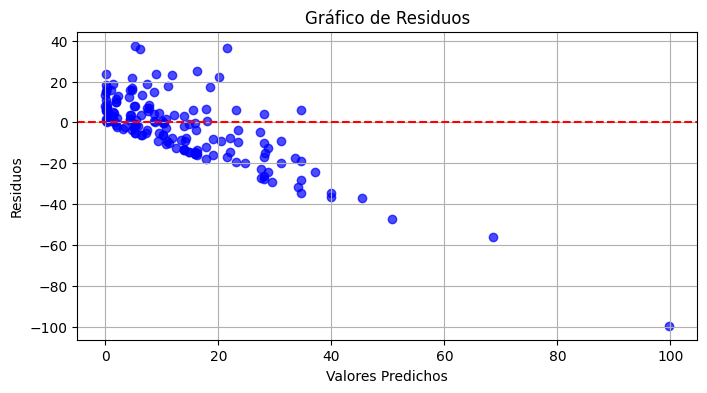

In [314]:
# Calcular los residuos
residuos = [real - pred for real, pred in zip(y_test, predictions_1)]

plt.figure(figsize=(8, 4))
plt.scatter(predictions_1, residuos, color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea en y=0
plt.title('Gráfico de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()


## Modelo 2:

In [315]:
from sklearn.ensemble import GradientBoostingRegressor

regressor_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
regressor_2.fit(x_train, y_train)
predictions_2 = regressor_2.predict(x_test)
save_metrics(regressor_2, y_test, predictions_2)

### Impacto de Variables en el Modelo 2

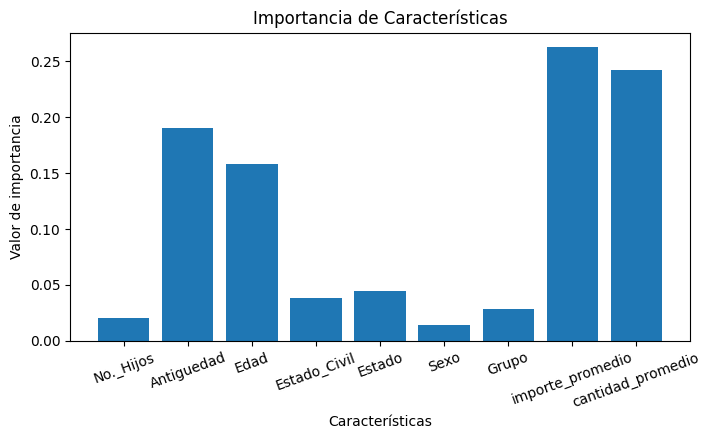

In [316]:
plt.figure(figsize=(8, 4))
plt.bar(regressor_2.feature_names_in_, regressor_2.feature_importances_)
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Valor de importancia')
plt.xticks(rotation=20)
plt.show()

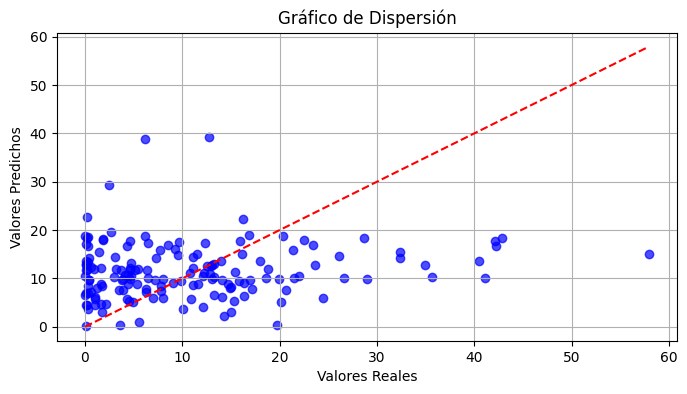

In [322]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(y_test, predictions_2, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Gráfico de Dispersión')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()


### Evaluación de Modelo 2

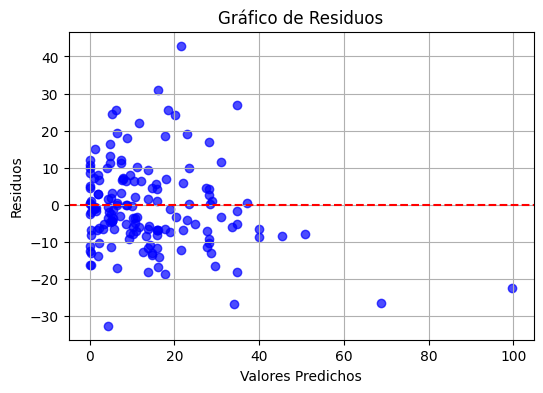

In [318]:
# Calcular los residuos
residuos = [real - pred for real, pred in zip(y_test, predictions_2)]

plt.figure(figsize=(6, 4))
plt.scatter(predictions_1, residuos, color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea en y=0
plt.title('Gráfico de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()


# Conclusiones

Vemos que `GradientBoostingRegressor` nos da mejores resultados comparados a `DecisionTreeRegressor`, no usamos modelos de regresión lineal, polinómica, ridge, lasso, debido a que la naturaleza de los datos como se ven en las `gráficas de dispersión`, no se ajustan a una recta ya sea lineal o polinómica, vemos que nuestro score de clientes va de 0-100 pero obtenemos un `rmse` de 11.48, lo cual indica que tenemos un 10% de variación, lo cual es un buen indicador de nuestro modelo.  

In [321]:
pd.DataFrame(list_metrics,columns=['model_name','root_mean_square_error','r2'])

,model_name,root_mean_square_error,r2
0,DecisionTreeRegressor,17.430798,-1.669506
1,GradientBoostingRegressor,11.484618,-0.158856
